In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from timm.scheduler import CosineLRScheduler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import ConcatDataset
from collections import Counter


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 사용 디바이스: {DEVICE}")

✅ 사용 디바이스: cuda


In [27]:
print("✅ GPU 사용 여부:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("🖥️ GPU 이름:", torch.cuda.get_device_name(0))

✅ GPU 사용 여부: True
🖥️ GPU 이름: NVIDIA RTX 4000 Ada Generation


In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS_PRETRAIN = 30
EPOCHS_FINETUNE = 30
PATIENCE = 10
MODEL_NAME = 'vit_base_patch16_224'
LR_PRETRAIN = 5e-5
LR_FINETUNE = 5e-6
DROPOUT = 0.5

# === 경로 설정 ===
photo_train = "/workspace/datasets/dataset2yolo/photo/train"
photo_val = "/workspace/datasets/dataset2yolo/photo/val"
drawing_train1 = "/workspace/datasets/dataset2yolo/drawing/train"
drawing_train2 = "/workspace/datasets/dataset2yolo/test_AI"
drawing_val = "/workspace/datasets/dataset2yolo/drawing/val"
photo_model_path = "/workspace/models/DeiT/Deit_pretrained_photo_ai.pth"
drawing_model_path = "/workspace/models/DeiT/Deit_finetuned_drawing_ai.pth"

# === ImageNet 정규화 ===
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
# === 데이터 증강 ===
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # 약하게 조정
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 강도 낮춤
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [30]:
def get_dataloaders(train_dir1, val_dir, train_dir2=None, use_weight=False):
    from torchvision import datasets
    from torch.utils.data import ConcatDataset

    # ✅ 1. train 데이터셋 만들기
    dataset1 = datasets.ImageFolder(train_dir1, transform=train_transform)

    if train_dir2:
        dataset2 = datasets.ImageFolder(train_dir2, transform=train_transform)
        train_dataset = ConcatDataset([dataset1, dataset2])
        train_dataset.classes = dataset1.classes  # class name 유지
        train_dataset.class_to_idx = dataset1.class_to_idx
    else:
        train_dataset = dataset1

    # ✅ 2. validation 데이터셋
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

    # ✅ 3. 클래스 가중치 계산
    if use_weight:
        if train_dir2:
            targets = [label for ds in [dataset1, dataset2] for _, label in ds.samples]
        else:
            targets = [label for _, label in train_dataset.samples]

        class_counts = Counter(targets)
        class_weights = [1.0 / class_counts[t] for t in targets]
        sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=8, pin_memory=True)
        weight_tensor = torch.tensor([1.0 / class_counts[i] for i in range(NUM_CLASSES)], dtype=torch.float32).to(DEVICE)
    else:
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
        weight_tensor = None

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
    return train_loader, val_loader, dataset1.classes, weight_tensor


In [31]:
def train_model(model, train_loader, val_loader, save_path, epochs, lr, class_weights=None):
    class FocalLoss(nn.Module):
        def __init__(self, alpha=1, gamma=2, weight=None):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.ce = nn.CrossEntropyLoss(weight=weight)

        def forward(self, inputs, targets):
            logp = self.ce(inputs, targets)
            p = torch.exp(-logp)
            loss = self.alpha * (1 - p) ** self.gamma * logp
            return loss

    criterion = FocalLoss(alpha=1, gamma=2, weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = CosineLRScheduler(optimizer, t_initial=epochs, lr_min=1e-6,
                                   warmup_t=5, warmup_lr_init=1e-6, cycle_limit=1)

    best_val_acc = 0
    patience_counter = 0

    # ⬇️ 추적용 리스트
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    all_preds, all_labels = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        print(f"\n📘 Epoch {epoch+1}/{epochs}")

        for imgs, labels in tqdm(train_loader, desc="🟦 Training", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)

        # 🔸 검증 단계
        model.eval()
        val_loss, val_correct = 0, 0
        all_preds, all_labels = [], []
        for imgs, labels in tqdm(val_loader, desc="🟨 Validating", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_acc = val_correct / len(val_loader.dataset)
        scheduler.step(epoch + 1)

        # 🔹 출력
        print(f"📊 Epoch {epoch+1}: "
              f"Train Loss = {train_loss/len(train_loader):.4f}, "
              f"Train Acc = {train_acc:.4f} | "
              f"Val Loss = {val_loss/len(val_loader):.4f}, "
              f"Val Acc = {val_acc:.4f}")

        # 🔹 리스트 저장
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # 🔹 Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("🛑 Early stopping!")
                break

    return all_preds, all_labels, train_losses, val_losses, train_accs, val_accs


In [32]:
# # === Step 1: 사진 학습 ===
# photo_train_loader, photo_val_loader, class_names, _ = get_dataloaders(
#     train_dir1=photo_train,
#     val_dir=photo_val,
#     train_dir2=None,  # 또는 생략 가능
#     use_weight=False
# )

# model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES, drop_rate=DROPOUT)
# model.to(DEVICE)

# train_model(model, photo_train_loader, photo_val_loader,
#             save_path=photo_model_path,
#             epochs=EPOCHS_PRETRAIN,
#             lr=LR_PRETRAIN,
#             class_weights=None)


In [ ]:
# 🔄 사진 학습은 생략하고 모델만 불러옴
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES, drop_rate=DROPOUT)
model.load_state_dict(torch.load(photo_model_path))
model.to(DEVICE)

# ✅ 그림 데이터 로더 정의
drawing_train_loader, drawing_val_loader, _, drawing_weights = get_dataloaders(
    drawing_train1, drawing_train2, drawing_val, use_weight=True)

# ✅ 파인튜닝만 수행
train_model(model,
            train_loader=drawing_train_loader,
            val_loader=drawing_val_loader,
            save_path=drawing_model_path,
            epochs=EPOCHS_FINETUNE,
            lr=LR_FINETUNE,
            class_weights=drawing_weights)



📘 Epoch 1/30


📊 Epoch 1: Train Loss = 0.8454, Train Acc = 0.2660 | Val Loss = 1.1831, Val Acc = 0.2141

📘 Epoch 2/30


📊 Epoch 2: Train Loss = 0.4759, Train Acc = 0.5027 | Val Loss = 1.3417, Val Acc = 0.3123

📘 Epoch 3/30


📊 Epoch 3: Train Loss = 0.2396, Train Acc = 0.7006 | Val Loss = 1.5626, Val Acc = 0.3350

📘 Epoch 4/30


📊 Epoch 4: Train Loss = 0.1775, Train Acc = 0.7479 | Val Loss = 0.6797, Val Acc = 0.4786

📘 Epoch 5/30


📊 Epoch 5: Train Loss = 0.1042, Train Acc = 0.7961 | Val Loss = 1.2650, Val Acc = 0.3652

📘 Epoch 6/30


📊 Epoch 6: Train Loss = 0.0818, Train Acc = 0.8165 | Val Loss = 1.5550, Val Acc = 0.2897

📘 Epoch 7/30


📊 Epoch 7: Train Loss = 0.0623, Train Acc = 0.8334 | Val Loss = 0.9610, Val Acc = 0.5239

📘 Epoch 8/30


📊 Epoch 8: Train Loss = 0.0318, Train Acc = 0.8757 | Val Loss = 1.1025, Val Acc = 0.4383

📘 Epoch 9/30


📊 Epoch 9: Train Loss = 0.0252, Train Acc = 0.8906 | Val Loss = 1.0256, Val Acc = 0.4257

📘 Epoch 10/30


📊 Epoch 10: Train Loss = 0.0209, Train Acc = 0.8921 | Val Loss = 0.9925, Val Acc = 0.4433

📘 Epoch 11/30


📊 Epoch 11: Train Loss = 0.0136, Train Acc = 0.9050 | Val Loss = 1.0508, Val Acc = 0.4710

📘 Epoch 12/30


📊 Epoch 12: Train Loss = 0.0131, Train Acc = 0.9150 | Val Loss = 1.1652, Val Acc = 0.4332

📘 Epoch 13/30


📊 Epoch 13: Train Loss = 0.0120, Train Acc = 0.9095 | Val Loss = 1.1116, Val Acc = 0.4912

📘 Epoch 14/30


📊 Epoch 14: Train Loss = 0.0102, Train Acc = 0.9125 | Val Loss = 1.2969, Val Acc = 0.4761

📘 Epoch 15/30


🟦 Training:   2%|▏         | 1/63 [00:01<01:12,  1.16s/it]

In [ ]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_losses = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_losses.append(loss.item())

    # ✅ 평균 정확도 및 평균 손실
    acc = accuracy_score(all_labels, all_preds)
    avg_loss = sum(all_losses) / len(all_losses)

    # ✅ 분류 리포트 (Precision, Recall, F1, per class accuracy)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print(f"\n🎯 Final Evaluation")
    print(f"✅ Average Accuracy: {acc:.4f}")
    print(f"📉 Average Loss: {avg_loss:.4f}")
    print("📊 Classification Report:")
    print(report)

    # ✅ Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 4))

        # 🔹 Loss 그래프
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Val Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.legend()
        plt.grid(True)

        # 🔹 Accuracy 그래프
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accs, label='Train Accuracy')
        plt.plot(epochs, val_accs, label='Val Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Curve")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

📊 Final Result Evaluation

🎯 Final Evaluation
✅ Average Accuracy: 0.3300
📉 Average Loss: 2.1267
📊 Classification Report:
              precision    recall  f1-score   support

       angry     0.3430    0.7108    0.4627        83
        fear     0.3333    0.2947    0.3128        95
       happy     1.0000    0.2148    0.3536       149
         sad     0.1101    0.1714    0.1341        70

    accuracy                         0.3300       397
   macro avg     0.4466    0.3479    0.3158       397
weighted avg     0.5462    0.3300    0.3280       397



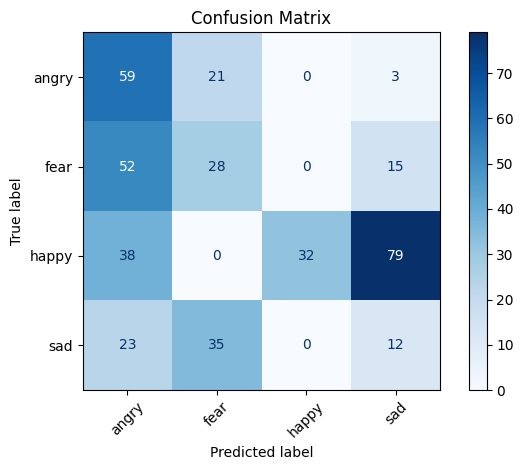

In [ ]:
# === 평가 ===
print("📊 Final Result Evaluation")
evaluate_model(model, drawing_val_loader, class_names)
plot_training_curves(train_losses, val_losses, train_accs, val_accs)